In [1]:
import random
from numpy.core.fromnumeric import size
import pygame
import sys
from pygame.surfarray import pixels2d
import pymunk
import pymunk.pygame_util
import numpy
import numpy as np
import math
from math import cos, inf, pi
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time

pygame 2.1.2 (SDL 2.0.18, Python 3.9.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
def draw_people():
    global infectlist #
    screen.fill((217,217,217))
    for i in range(population):
        pygame.draw.circle(screen, colors[tribe[i]], (x[i], y[i]), 3)

    # Draw lines showing infections
    #for infection in infectlist:
        #pygame.draw.line(screen, colors[tribe[infection[0]]],(x[infection[0]],y[infection[0]]), (x[infection[1]],y[infection[1]]))
    infectlist=[]

In [3]:
##def move_people(trialnumber): #trial 0=red 1=blue
"""
    colorxboundary = xres
    coloryboundary = yres
    #x=np.minimum(np.maximum(x,0),colorxboundary-1e-6)
    #y=np.minimum(np.maximum(y,0),coloryboundary-1e-6）
"""
def move_people():
    global theta, x, y, xres, yres
    d = 1
    theta += dtheta*(np.random.random(population)-.5)
    x += d * np.cos(theta)
    y += d * np.sin(theta)    

# Reflecting BC's
    flip=np.where(x<0)
    x[flip] = x[flip] + 800 #torus
    #x[flip]=-x[flip] #box
    #theta[flip]=pi-theta[flip]
    flip=np.where(x>=xres)
    x[flip] = x[flip] - 800 #torus
    #x[flip]=2*xres-x[flip]-1e-6 #box
    #theta[flip]=pi-theta[flip]
    flip=np.where(y<0)
    y[flip] = y[flip] +800 #torus
    #y[flip]=-y[flip] #box
    #theta[flip]=-theta[flip]
    flip=np.where(y>=yres)
    y[flip] = y[flip]- 800 #torus
    #y[flip]=2*yres-y[flip]-1e-6 #box
    #theta[flip]=-theta[flip]


# This just keeps them in the box
    #x=np.minimum(np.maximum(x,0),xres-1e-6)
    #y=np.minimum(np.maximum(y,0),yres-1e-6）

In [4]:
def bin_people():
    global ix, iy
    ixold=ix #Keep track of old bin assignments
    iyold=iy
    ix=(x/P).astype(int) #Get new bin assignments
    iy=(y/P).astype(int)
    moved=np.where(np.logical_or(ixold != ix,iyold != iy))[0] #Get list of people that have moved bins
    for i in moved: #Update bin lists
        try:
            patches[ixold[i]][iyold[i]].remove(i)
        except ValueError:
            pass
        patches[ix[i]][iy[i]].append(i)

    # Check if patch is uniform (can accelerate searching for interactions between different tribes)
    for i in range(nx):
        for j in range(ny):
            if patches[i][j]:
                ptribe[i,j]=tribe[patches[i][j][0]] if np.all(tribe[patches[i][j]]==tribe[patches[i][j][0]]) else MIXED
            else:
                ptribe[i,j]=MIXED


In [5]:
FluxListBlue = []
FluxListRed = []
Reacttime = []

def infect():
    reactiontime = time.time() - starttime

    bin_people()
    oldtribe=tribe.copy()

    for i1 in range(nx): # Loop over bins (in x)
        for j1 in range(ny): # Loop over bins (in y)
            if not patches[i1][j1]: #patch is empty
                continue
            for off in offsets:  # Loop over list of relative bin coords to check
                i2=i1+off[0] # Get neighboring bin index
                j2=j1+off[1]
                if i2 < 0 or i2 > nx-1 or j2 < 0 or j2 > ny-1: #Check that neighboring bin exists and is not outside of domain
                    continue
                if not patches[i2][j2]:
                    continue
                if ptribe[i1,j1] != MIXED and ptribe[i1,j1]==ptribe[i2,j2]:
                    continue #Both patches are uniform and have same tribe
                for p1 in patches[i1][j1]: #Loop over people in patch [i,j]
                    for p2 in patches[i2][j2]: #Loop over people in neighboring patch
                        if (i1 == i2 and j1 == j2 and p2 <= p1):
                            continue #Avoid double checking neighbors on self-patch
                        if (x[p1]-x[p2])**2 + (y[p1]-y[p2])**2 < D2:  #Check if neighboring person in range

                            # Infection logic (2 way)
                            if tribe[p2] != oldtribe[p1]:
                                tolerance[p2] = tolerance[p2] - 1


                                if tolerance[p2] <= 0:
                                    infectlist.append([p1, p2]) #
                                    tolerance[p2] = 1000 #THIS IS JUST FOR THE LOGIC STATEMENT, NOT PERMANENT

                            if tribe[p1] != oldtribe[p2]:
                                tolerance[p1] = tolerance[p1] - 1

                                if tolerance[p1] <= 0:
                                    infectlist.append([p2, p1]) #
                                    tolerance[p1] = 1000 #THIS IS JUST FOR THE LOGIC STATEMENT, NOT PERMANENT

    # Counting Flux Initialization

    FluxCounterBlue = 0  # (Red to blue)

    FluxCounterRed = 0  # (Blue to red)
    for infection in infectlist: #
        if tribe[infection[1]] == 0: #if the infected was /is red
            #tolerance[infection[1]] = average
            tolerance[infection[1]] = distribution[random.randint(0, int(population)-1)]
            FluxCounterBlue = FluxCounterBlue + 1 #Infected by Blue

        if tribe[infection[1]] == 1: #if the infected was/ is blue
            tolerance[infection[1]] = average
            #tolerance[infection[1]] = distribution_2nd[random.randint(0, int(population)-1)]
            FluxCounterRed = FluxCounterRed + 1 #Infected by red

        #tolerance[infection[1]] = oldtolerance[infection[0]] # new tolerance is original tolerance of infector
        tribe[infection[1]] = oldtribe[infection[0]]
        # updates tolerances and tribes of infected individuals
    for infection in infectlist: #
        oldtolerance[infection[1]] = tolerance[infection[1]]

    FluxListBlue.append(FluxCounterBlue)
    FluxListRed.append(FluxCounterRed)
    Reacttime.append(reactiontime)
    if max(Reacttime) > 20.0 and max(Reacttime) < 20.01:
        #tolerancelist5 = tolerancelist[:len(tolerancelist)//2]
        #tolerancelist6 = tolerancelist[len(tolerancelist)//2:]
        #plt.hist([tolerancelist5,tolerancelist6])
            #continue
        print(max(Reacttime))

        


def infect2(): #Simpler brute force approach
    mask =np.power(np.subtract.outer(x, x),2) + np.power(np.subtract.outer(y, y),2) < D2

    for i in range(population):
        targets = (np.where(mask[i,:]))[0]
        for j in targets:
            # Infection logic (1 way)
            if tolerance[i] > tolerance[j]:
                tribe[j]=tribe[i]
                tolerance[j]=tolerance[i]


In [6]:
# INIT
pygame.init()
xres=800
yres=800
screen = pygame.display.set_mode((xres, yres))
clock = pygame.time.Clock()
surface = pygame.Surface((10, 10))
space = pymunk.Space()
#options = pymunk.pygame_util.DrawOptions(surface)
#space.debug_draw(options)
#space.gravity = (0, 500)

#initialization
population = 1111
x = np.zeros(population)
y = np.zeros(population)
theta = np.random.random(population)*pi*2
tribe = np.zeros(population, dtype=int)
ix=np.zeros(population, dtype=int)-1
iy=np.zeros(population, dtype=int)-1
tolerance = np.zeros(population)



WHITE =     (255, 255, 255)
BLUE =      (  0,   0, 255)
GREEN =     (  0, 255,   0)
RED =       (255,   0,   0)

MIXED =-1 # Patches 'Tribe' when mixed
colors = [RED, BLUE]
dtheta = random.uniform(0,1) #angular step size in radians
d=2 #distance in pixels per tick

D = 15 #infect distance
P = 40 # Patch size -  Making this smaller means particles will cross patch boundaries more frequently causing overhead.
       #               Making it larger means there are more particles to consider for distance calculations

D2=D**2
nx=np.ceil(xres/P).astype(int)
ny=np.ceil(yres/P).astype(int)

patches=[ [ [] for i in range(nx)] for j in range(ny)]

ptribe=np.zeros([nx,ny],dtype=int)+MIXED

nxoff=np.ceil(D/P).astype(int)
offsets=[]
for i in range(-nxoff,nxoff):
    for j in range(-nxoff,nxoff):
        if (j > 0 or (j==0 and i >= 0)):
            if (i**2+j**2)**0.5 < 2**0.5+D/P: #Patch is close enough to have overlaps
                offsets.append([i,j])

infectlist=[]

average = 10
stdev = 2.25
distribution = np.random.normal(average, stdev, int(population))
# distri 2
average_2nd = 10
stdev_2nd = 2
distribution_2nd = np.random.normal(average_2nd, stdev_2nd, int(population))


for i in range(1000):#int(population/2)):
    x[i] = 200
    y[i] = 400
    tribe[i] = 0 #(red)
    tolerance[i] = average #CHANGE LATER
    #tolerance[i] = distribution_2nd[i]


for i in range(1000, population):
    x[i] = 600
    y[i] = 400
    tribe[i] = 1 #blue
    tolerance[i] = distribution[i] #CHANGE LATER
    #tolerance[i] = average #This is for checking the "base case" where variance is 0
    if tolerance[i] <= 0:
        tolerance[i] = 0
oldtolerance=tolerance.copy()
winner = 0


def find_red_tol(tolerance):
    Red_list = []
    for i in range(population):
        if tolerance[i][0] != 0:
            Red_list.append(tolerance[i][0])
        else: 
            continue
    return Red_list
def find_blue_tol(tolerance):
    Blue_list = []
    for i in range(population):
        if tolerance[i][1] != 0:
            Blue_list.append(tolerance[i][1])
        else: 
            continue
    return Blue_list
def change_color_new(list_1):
    y = list_1.index(max(list_1))
    if y == 0: # change red to blue
        list_1[0] = 0
        list_1[1] = distribution[random.randint(0, int(population)-1)]
        return list_1
    else:#change blue to red
        list_1[0] = average
        list_1[1] = 0
        return list_1
def tol_minus_1(list_1):#list_1 is a list with only two elements
    #print(list_1) # make the original (0,1) to (0,0) know  change which one
    x = max(list_1)
    y = list_1.index(x)
    if x > 1:
        x -= 1
        list_1[y] = x
    elif x<=1:
        list_1 = change_color_new(list_1)
    else:
        print(1)
    
    return list_1
#    print(list_2)
#    _1_ = float(list_1[1])
#    _0_ = float(list_1[0])
    
#    #if list_1[0] == list_1[1]:
#        #return print(list_1[0],list_1[1],"it should not have same number")
#    if _1_ < 0 or _0_ < 0:
#        return print(list_1[0],list_1[1],"it should not be negative, next loop has problem")
#    elif list_1[0] != 0:
#        list_1[0] -= 1
#        if list_1[0] <= 0:
#            list_1 = change_color(list_1, list_2)
#        return list_1
#    elif list_1[1] != 0:
#        list_1[1] -= 1
#        if list_1[1] <= 0:
#            list_1 = change_color(list_1,list_2)
#        return list_1
#    else:
#        return print(list_1[0],list_1[1],"what happenned")

def change_color(list_1, list_2): #list_1 & list_2 are lists with only two elements  list_2 is the original list
    # it not change the color ,it change the position that has value of two list
    if list_2[0] - list_1[0] != 0: # changing partical is red, it should change to blue
        list_1[0] = 0
        list_1[1] = distribution[random.randint(0, int(population)-1)]
        return list_1
    elif list_2[1] - list_1[1] != 0:
        list_1[0] = average
        list_1[1] = 0
        return list_1
    else:
        print(list_1, list_2)

#    if list_1[0] == list_1[1]:
#        return print(list_1[0],list_1[1],"it should not have same number_changecolor")
#    elif list_1[1] < 0 and list_1[0]<0:
#        return print(list_1[0],list_1[1],"it should not be negative, next loop has problem")
#    elif list_1[0] < 0: #it should change from red to blue
#        list_1[0] = 0
#        list_1[1] = distribution[random.randint(0, int(population)-1)]
#        return list_1
#    elif list_1[1] < 0: # it should change from blue to red
#        list_1[1] = 0
#        list_1[0] = average
#        return list_1
#    else:
#        print(1)

111


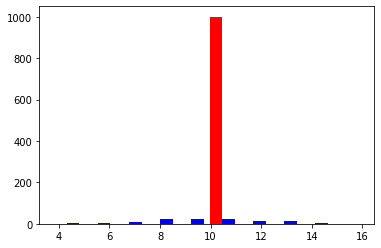

In [7]:
screen.fill((217, 217, 217))

draw_people()

tolerancelist_ori = tolerance.tolist()
#####get another type of list with [red, blue
every_tol = []
population_r = []
population_b = []
for i in range(len(tolerancelist_ori)):#tolerancelist_ori:
    if i < 1000:#len(tolerancelist_ori)/2:
        element = [tolerancelist_ori[i],0]
        every_tol.append(element)
    else:
        every_tol.append([0,tolerancelist_ori[i]])
bins = int(max(tolerancelist_ori))
#tolerancelist3 = tolerancelist_ori[:len(tolerancelist_ori)//2] # red list
tolerancelist0_r = find_red_tol(every_tol)
#tolerancelist4 = tolerancelist_ori[len(tolerancelist_ori)//2:] # blue list
tolerancelist0_b = find_blue_tol(every_tol)
plt.hist([tolerancelist0_r,tolerancelist0_b], color=['red', 'blue'])#, bins, range, color=['red', 'blue'], histtype='bar', rwidth=0.8)
print(len(tolerancelist0_b))

Total red flux =  14184
Total blue flux =  15183
Blue has 999 more switches than red
Winner is blue


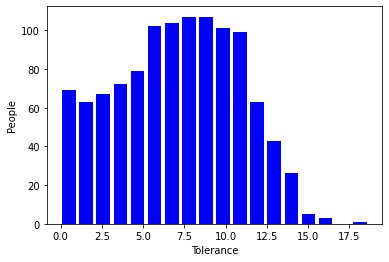

In [8]:
# Run game
starttime = time.time()
while True:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            print("Total red flux = ", TotalRedFlux)
            print("Total blue flux = ", TotalBlueFlux)
            print("Blue has", BlueisUpBy, "more switches than red")
            tolerancelist_fnsh = tolerance.tolist()
            print(tolerancelist)
            range = (0,max(tolerancelist))
            bins = int(max(tolerancelist))
            tolerancelist1 = tolerancelist_fns[:len(tolerancelist_fns)//2]
            
            tolerancelist2 = tolerancelist_fns[len(tolerancelistfns)//2:]
            
            plt.hist([tolerancelist1,tolerancelist2], bins, range, color=['red', 'blue'],histtype='bar', rwidth=0.8)

            plt.show()

            pygame.quit()
            sys.exit()

    screen.fill((217, 217, 217))

    draw_people()
    
    move_people()
###################################################################################################################################    
    reactiontime = time.time() - starttime

    bin_people()
    oldtribe=tribe.copy()
    for i1 in range(nx): # Loop over bins (in x)
    
        ##if i1 < 1/4*(nx): 
            
            
            ##FluxListBlue.remove(FluxCounterBlue)
            
            
        ##if i1 > 3/4*(nx):
        
            ##FluxListRed.remove(FluxCounterRed)
        
        for j1 in range(ny): # Loop over bins (in y)
            if not patches[i1][j1]: #patch is empty
                continue
            for off in offsets:  # Loop over list of relative bin coords to check
                i2=i1+off[0] # Get neighboring bin index
                j2=j1+off[1]
                if i2 < 0 or i2 > nx-1 or j2 < 0 or j2 > ny-1: #Check that neighboring bin exists and is not outside of domain
                    continue
                if not patches[i2][j2]:
                    continue
                if ptribe[i1,j1] != MIXED and ptribe[i1,j1]==ptribe[i2,j2]:
                    continue #Both patches are uniform and have same tribe
                for p1 in patches[i1][j1]: #Loop over people in patch [i,j]
                    for p2 in patches[i2][j2]: #Loop over people in neighboring patch
                        if (i1 == i2 and j1 == j2 and p2 <= p1):
                            continue #Avoid double checking neighbors on self-patch
                        if (x[p1]-x[p2])**2 + (y[p1]-y[p2])**2 < D2:  #Check if neighboring person in range
                            
                            
                            if x[p1] == 250 and y[p1] == 250:   #setting the new bd for the blue
                            
                                x[p1] == 250
                                
                                y[p1] ==250
                        
                            if x[p2] == 250 and y[p2] == 250:  #setting the new bd for the red
                                
                                x[0] *= -1
                                
                                y[p2] = numpy.flip(p2,y)
                                
                                y[0] *= -1
                                
                            # Infection logic (2 way)
                            if tribe[p2] != oldtribe[p1]:
                                #print(p2,tolerance[p2],every_tol[p2])
                                tolerance[p2] = tolerance[p2] - 1
                                ################chaprnge my new created list###############
                                #list_1 = every_tol[p2] 
                                #every_tol[p2] = tol_minus_1(list_1)
                                ##thisx = max(every_tol[p2])
                                ##thisy = every_tol[p2].index(thisx)
                                ##if thisx > 1:
                                ##    thisx -= 1
                                ##    every_tol[p2][thisy] = thisx
                                ##elif thisx<=1:
                                ##    every_tol[p2] = change_color_new(every_tol[p2])
                                ##else:
                                ##    print(1)
#                                if every_tol[p2][0] < 0 or every_tol[p2][1] < 0:
#                                    change_color(every_tol[p2])
#                                else:
#                                    continue

                                if tolerance[p2]<= 0:
        #####Maker
                                    infectlist.append([p1, p2]) #
                                    tolerance[p2] = 1000 #THIS IS JUST FOR THE LOGIC STATEMENT, NOT PERMANENT
                                    

                        if tribe[p1] != oldtribe[p2]:
                            tolerance[p1] = tolerance[p1] - 1
                            every_tol[p1] = tol_minus_1(every_tol[p1])
#                                if every_tol[p1][0] < 0 or every_tol[p1][1] < 0:
#                                    change_color(every_tol[p1])
#                                else:
#                                    continue

                            if tolerance[p1] <= 0:
                                infectlist.append([p2, p1])#
                                tolerance[p1] = 1000 #THIS IS JUST FOR THE LOGIC STATEMENT, NOT PERMANENT
#                                    change_color(every_tol[p1])"""
        

    # Counting Flux Initialization
    

    FluxCounterBlue = 0  # (Red to blue)

    FluxCounterRed = 0  # (Blue to red)
    for infection in infectlist: #
        if tribe[infection[1]] == 0: #if the infected was /is red
            #tolerance[infection[1]] = average
            tolerance[infection[1]] = distribution[random.randint(0, int(population)-1)]
            FluxCounterBlue = FluxCounterBlue + 1 #Infected by Blue
            #####Maker
            #Blue_list.append(tolerance[infection[1]])

        if tribe[infection[1]] == 1: #if the infected was/ is blue
            tolerance[infection[1]] = average
            #tolerance[infection[1]] = distribution_2nd[random.randint(0, int(population)-1)]
            FluxCounterRed = FluxCounterRed + 1 #Infected by red
            #Red_list.append(average)

        #tolerance[infection[1]] = oldtolerance[infection[0]] # new tolerance is original tolerance of infector
        tribe[infection[1]] = oldtribe[infection[0]]
        # updates tolerances and tribes of infected individuals
    for infection in infectlist:
        oldtolerance[infection[1]] = tolerance[infection[1]]

    
    FluxListBlue.append(FluxCounterBlue)
    FluxListRed.append(FluxCounterRed)
    Reacttime.append(reactiontime)
    ##curr_b_pop = sum(tribe)#len(find_red_tol(every_tol))
    ##curr_r_pop = population - curr_b_pop#len(find_blue_tol(every_tol))
    ##population_r.append(curr_r_pop)
    ##population_b.append(curr_b_pop)
    
    #name_r = "tolerancelist" + str(max(Reacttime))+"_r"
    #name_b = "tolerancelist" + str(max(Reacttime))+"_b"
    ##if max(Reacttime) > 5.0 and max(Reacttime) < 5.015:
    ##    tolerancelist_sp1 = tolerance.tolist()  
    ##    tolerancelist5_r = find_red_tol(every_tol)
    ##    tolerancelist5_b = find_blue_tol(every_tol)
        #print(max(Reacttime))
    ##if max(Reacttime) > 10.0 and max(Reacttime) < 10.015:
    ##    tolerancelist_sp1 = tolerance.tolist()  
        #tolerancelist5 = tolerancelist_sp1[:len(tolerancelist_sp1)//2]
    ##    tolerancelist10_r = find_red_tol(every_tol)
        #tolerancelist6 = tolerancelist_sp1[len(tolerancelist_sp1)//2:]
    ##    tolerancelist10_b = find_blue_tol(every_tol)
        #plt.hist([tolerancelist5,tolerancelist6])
            #continue
        #print(max(Reacttime))
        
    ##if max(Reacttime) > 15.0 and max(Reacttime) < 15.015:
    ##    tolerancelist_sp1 = tolerance.tolist()  
    ##     tolerancelist15_r = find_red_tol(every_tol)
    ##     tolerancelist15_b = find_blue_tol(every_tol)
        #print(max(Reacttime))
        
    ## if max(Reacttime) > 20.0 and max(Reacttime) < 20.015:
    ##     tolerancelist_sp2 = tolerance.tolist()  
        #tolerancelist7 = tolerancelist_sp2[:len(tolerancelist_sp2)//2]
        #tolerancelist8 = tolerancelist_sp2[len(tolerancelist_sp2)//2:]
    ##     tolerancelist20_r = find_red_tol(every_tol)
    ##     tolerancelist20_b = find_blue_tol(every_tol)
        #plt.hist([tolerancelist5,tolerancelist6])
            #continue
        #print(max(Reacttime))
    ## if max(Reacttime) > 25.0 and max(Reacttime) < 25.015:
    ##     tolerancelist_sp1 = tolerance.tolist()  
    ##     tolerancelist25_r = find_red_tol(every_tol)
    ##     tolerancelist25_b = find_blue_tol(every_tol)
        #print(max(Reacttime))
        
    ## if max(Reacttime) > 30.0 and max(Reacttime) < 30.015:
    ##     tolerancelist_sp1 = tolerance.tolist()  
    ##     tolerancelist30_r = find_red_tol(every_tol)
    ##     tolerancelist30_b = find_blue_tol(every_tol)
        #print(max(Reacttime))
#####################################################################################################################    
 #   infect() #This uses particle binning (locality hashing) to accelerate finding nodes within a distance D
 #   infect2() #This is the simpler brute forch approach for finding nodes within a distance D
    #space.step(1/50)
    
    pygame.display.update()
    clock.tick()
    ##print(FluxListBlue)
    
    ##print(FluxListRed)
    if sum(tribe) == 0:#curr_r_pop == population:#
        winner = "red"
        print("Total red flux = ", TotalRedFlux)
        print("Total blue flux = ", TotalBlueFlux)
        print("Blue has", BlueisUpBy, "more switches than red")
    if sum(tribe)/len(tribe) == 1: #curr_b_pop == population:#
        winner = "blue"
        print("Total red flux = ", TotalRedFlux)
        print("Total blue flux = ", TotalBlueFlux)
        print("Blue has", BlueisUpBy, "more switches than red")
    if winner == "red" or winner == "blue":
        print("Winner is", winner)
        #print("Total red flux = ", TotalRedFlux)
        #print("Total blue flux = ", TotalBlueFlux)
        #print("Blue has", BlueisUpBy, "more switches than red")

        # This code creates a histogram of tolerances at the end of the experiment
        tolerancelist_fns = tolerance.tolist()
        #print(tolerancelist)
        
        range = (0, max(tolerancelist_fns))
        bins = int(max(tolerancelist_fns))
        #tolerancelist1 = tolerancelist[:len(tolerancelist) // 2]
        #tolerancelist2 = tolerancelist[len(tolerancelist) // 2:]
        plt.hist([tolerancelist_fns], bins, range, color= 'blue', histtype='bar', rwidth=0.8)
        plt.xlabel("Tolerance")
        plt.ylabel("People")
        #plt.savefig('A' + str(average) + "V" + str(stdev) + "EX2.png")
        
        plt.show()

        break
    #print(tolerance[150], tribe[150], oldtolerance[150])
    #print(np.mean(oldtolerance))

    TotalRedFlux = sum(FluxListRed)
    TotalBlueFlux = sum(FluxListBlue)
    BlueisUpBy = TotalBlueFlux - TotalRedFlux

# This is going to plot the tolerances across the RED (tribe 1) population
#x = np.arange(0, population / 2, 1)

#y = list(tolerance[0, population / 2])
#tick_label = ['']

#plt.bar(x, y)
#plt.show()


In [9]:
pygame.quit()
print(max(Reacttime))
#print(every_tol)

16.70158886909485


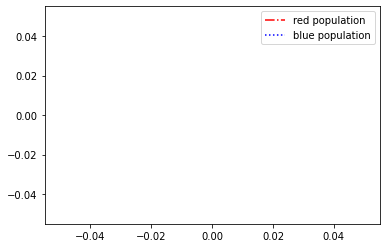

In [10]:

#plt.plot(x, y, label = "line 1", linestyle="-")
#plt.plot(y, x, label = "line 2", linestyle="--")
plt.plot(population_r, label = "red population", linestyle="-.",color='red')
plt.plot(population_b, label = "blue population", linestyle=":", color='blue')
plt.legend()
plt.show()

In [11]:
print(1)

1


In [12]:
plt.hist([tolerancelist5_r,tolerancelist5_b], color=['red', 'blue'])

NameError: name 'tolerancelist5_r' is not defined

In [ ]:
plt.hist([tolerancelist10_r,tolerancelist10_b], color=['red', 'blue'])

In [ ]:
plt.hist([tolerancelist15_r,tolerancelist15_b], color=['red', 'blue'])

In [ ]:
plt.hist([tolerancelist20_r,tolerancelist20_b], color=['red', 'blue'])

In [ ]:
plt.hist([tolerancelist25_r,tolerancelist25_b], color=['red', 'blue'])

In [ ]:
plt.hist([tolerancelist30_r,tolerancelist30_b], color=['red', 'blue'])